In [1]:
#import everything here
import vireoSNP
import numpy as np
import pandas as pd

from scipy import sparse
from scipy.io import mmread
from scipy.io import mmwrite
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager
import matplotlib as mpl
from vireoSNP import BinomMixtureVB

from mquad.mquad_utils import findKnee, plot_confusionMatrix, confusionMatrix

print(vireoSNP.__version__)
np.set_printoptions(formatter={'float': lambda x: format(x, '.5f')})

0.5.6


In [2]:
mquad_AD = mmread('data/mquad/passed_ad.mtx').tocsc()
mquad_DP = mmread('data/mquad/passed_dp.mtx').tocsc()

mquad_AD.shape, mquad_DP.shape

((24, 77), (24, 77))

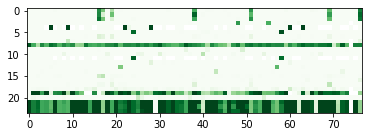

In [3]:
with open('data/mquad/passed_variant_names.txt') as f:
    var = f.readlines()

var = [x.strip() for x in var]

AD_df = pd.DataFrame(mquad_AD.todense(), index=var)
DP_df = pd.DataFrame(mquad_DP.todense(), index=var)

plt.imshow(AD_df/DP_df, cmap='Greens')

AF_df = AD_df/DP_df
AF_df = AF_df.fillna(0)


In [4]:
import scipy
new_AD = scipy.sparse.csc_matrix(AD_df.values)
new_DP = scipy.sparse.csc_matrix(DP_df.values)


np.random.seed(42)
_model = BinomMixtureVB(n_var=len(mquad_AD.getnnz(axis=1)), n_cell=len(mquad_AD.getnnz(axis=0)), n_donor=3)
_model.fit(mquad_AD, mquad_DP, min_iter=30, n_init=300)

mquad_modelCA = _model

Precision = 0.8484848484848485
Recall = 0.8888888888888888


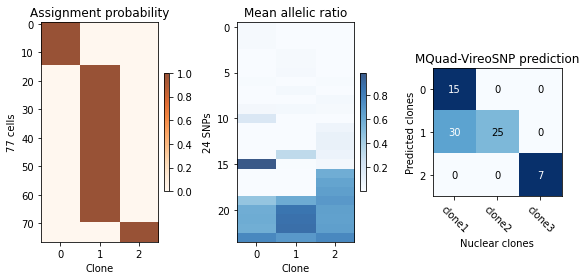

In [5]:
#assignment prob heatmap
from vireoSNP.plot.base_plot import heat_matrix

fig = plt.figure(figsize=(8,4))
plt.subplot(1,3,1)
ID_prob_sorted = np.array([[i[2], i[0], i[1]]for i in mquad_modelCA.ID_prob])
im = heat_matrix(ID_prob_sorted, cmap="Oranges", alpha=0.8,
                 display_value=False, row_sort=True, interpolation = 'none')
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.title("Assignment probability")
plt.xlabel("Clone")
plt.ylabel("%d cells" %(mquad_modelCA.n_cell))
plt.xticks(range(mquad_modelCA.n_donor))
plt.tight_layout()

plt.subplot(1,3,2)
AF_SNPs = mquad_modelCA.beta_mu
#rearrange clones to match fig 3b
AF_SNPs_sorted = np.array([[i[2], i[0], i[1]]for i in AF_SNPs])
im = heat_matrix(AF_SNPs_sorted, cmap="Blues", alpha=0.8, 
                 display_value=False, row_sort=True, interpolation='none', aspect='auto')
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.title("Mean allelic ratio")
plt.xlabel("Clone")
plt.ylabel("%d SNPs" %(mquad_modelCA.n_var))
plt.xticks(range(mquad_modelCA.n_donor))
plt.tight_layout()

#mquad confusion matrix
ax = plt.subplot(1,3,3)
clone_id = np.argmax(ID_prob_sorted, axis=1)

real_df = pd.read_csv('data/cardelino_clones_files.csv')
real_lab = [i for i in real_df.V2 if i != 'unassigned']
confusion = confusionMatrix(clone_id, real_lab)
#confusion = confusion[["Clone 1", "Clone 2", "Clone 3"]]
res = plot_confusionMatrix(confusion, ax)
plt.title('MQuad-VireoSNP prediction')
plt.ylabel('Predicted clones')
plt.xlabel('Nuclear clones')
plt.xticks(range(3), confusion.columns,rotation=315)
plt.yticks(range(len(confusion)), set(clone_id))
plt.tight_layout()

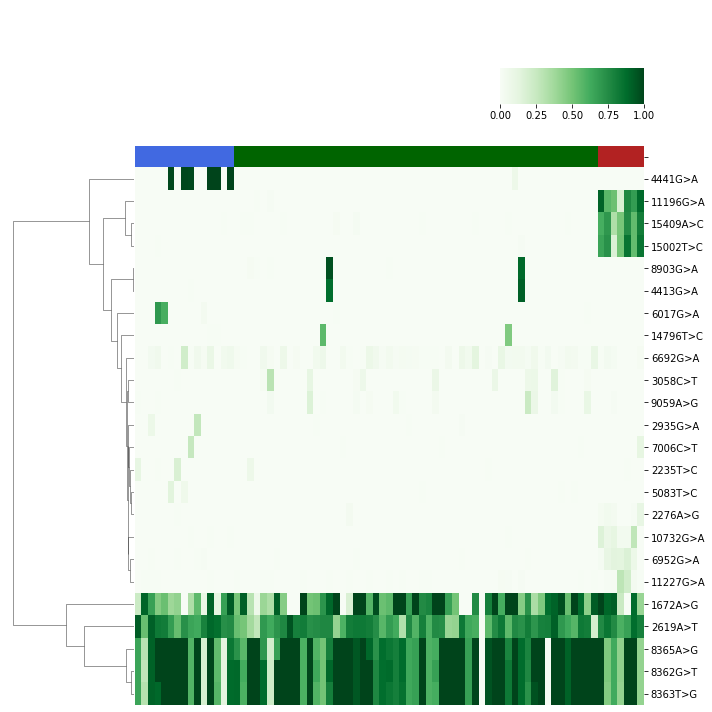

In [12]:
clone_id = np.argmax(ID_prob_sorted, axis=1)
col_idx = np.argsort(clone_id)
sorted_AF = AF_df.loc[:, col_idx]

clone_pal = ['royalblue', 'darkgreen', 'firebrick']
clone_lut = dict(zip(set(clone_id), clone_pal))
clone_colors = pd.Series(clone_id).map(clone_lut)

g = sns.clustermap(sorted_AF, col_cluster = False, row_cluster = True, xticklabels = False, cmap = 'Greens', col_colors = clone_colors, cbar_kws = dict(use_gridspec=False,orientation="horizontal"))
g.cax.set_position([.7, 0.85, .2, 0.05])

In [7]:
## save the clone assignment to pipe into R for DE analysis
d = {'mquad': clone_id, 'cardelino': real_lab}
clone_df = pd.DataFrame(d)
clone_df['combined'] = clone_df.cardelino + '.MT' + clone_df.mquad.astype(str)
clone_df.to_csv('data/clone_id.csv')

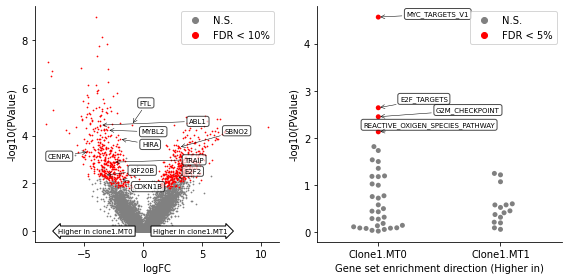

In [40]:
## Import gene expression analysis from R
from matplotlib.pyplot import Line2D
from adjustText import adjust_text
import re

de_tab = pd.read_csv('data/de_tab.csv', index_col=0)
cam_H_pw = pd.read_csv('data/cam_H_pw.csv', index_col=0)

fig = plt.figure(figsize=(8,4))
ax = plt.subplot(1,2,1)
de_tab_sig = de_tab[de_tab.sig == True]
de_tab_not_sig = de_tab[de_tab.sig == False]

ax.scatter(de_tab_not_sig.logFC, -np.log10(de_tab_not_sig.PValue), color = 'grey', label = 'N.S.', s=0.5)
ax.scatter(de_tab_sig.logFC, -np.log10(de_tab_sig.PValue), color='r', label = 'FDR < 10%', s=0.5)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
legend_elements = [Line2D([0], [0], marker = 'o', color = 'grey', label = 'N.S.', linestyle = 'None'), 
Line2D([0], [0], marker = 'o', color = 'r', label = 'FDR < 10%', linestyle = 'None')]
ax.legend(handles = legend_elements)
ax.text(-4, 0, 'Higher in clone1.MT0', ha='center', va='center', bbox = dict(boxstyle="larrow", fc='white', lw=1), fontsize = 7)
ax.text(4, 0, 'Higher in clone1.MT1', ha='center', va='center', bbox = dict(boxstyle="rarrow", fc='white', lw=1), fontsize = 7)
plt.xlabel('logFC')
plt.ylabel('-log10(PValue)')

texts = []
props = dict(boxstyle='round', alpha = 0.7, facecolor='white')
for x,y,s in zip(de_tab_sig[de_tab_sig.lab.notnull()].logFC, -np.log10(de_tab_sig[de_tab_sig.lab.notnull()].PValue), de_tab_sig[de_tab_sig.lab.notnull()].lab):
    texts.append(plt.text(x,y,s, fontsize = 7, bbox=props))

adjust_text(texts, force_text = 1.5, force_points = 1.5, expand_points=(1.5, 2), expand_text=(1.5, 1.5), arrowprops = dict(arrowstyle="->", color='black', lw=0.5))

ax = plt.subplot(1,2,2)
cam_H_pw_not_sig = cam_H_pw[cam_H_pw.sig == False]
cam_H_pw_sig = cam_H_pw[cam_H_pw.sig == True]
#cam_H_pw.head()

sns.swarmplot(x = cam_H_pw.Direction, y = -np.log10(cam_H_pw.PValue), hue = cam_H_pw.sig, palette = ['grey', 'r'], ax=ax)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

texts=[]
for y,s in zip(-np.log10(cam_H_pw_sig[cam_H_pw_sig.lab.notnull()].PValue), cam_H_pw_sig[cam_H_pw_sig.lab.notnull()].lab):
    s = re.sub("HALLMARK_", "", s)
    texts.append(plt.text(0,y,s, fontsize = 7, bbox=props))

adjust_text(texts, force_text = 1.5, force_points = 1.5, expand_points=(1.5, 2), expand_text=(1.5, 1.5), autoalign='y', ha='left',arrowprops = dict(arrowstyle="->", color='black', lw=0.5))

legend_elements = [Line2D([0], [0], marker = 'o', color = 'grey', label = 'N.S.', linestyle = 'None'), 
Line2D([0], [0], marker = 'o', color = 'r', label = 'FDR < 5%', linestyle = 'None')]
ax.legend(handles = legend_elements)
plt.xticks(range(2), ['Clone1.MT0', 'Clone1.MT1'])
plt.xlabel('Gene set enrichment direction (Higher in)')
plt.ylabel('-log10(PValue)')

plt.tight_layout()


Precision = 0.8484848484848485
Recall = 0.8888888888888888


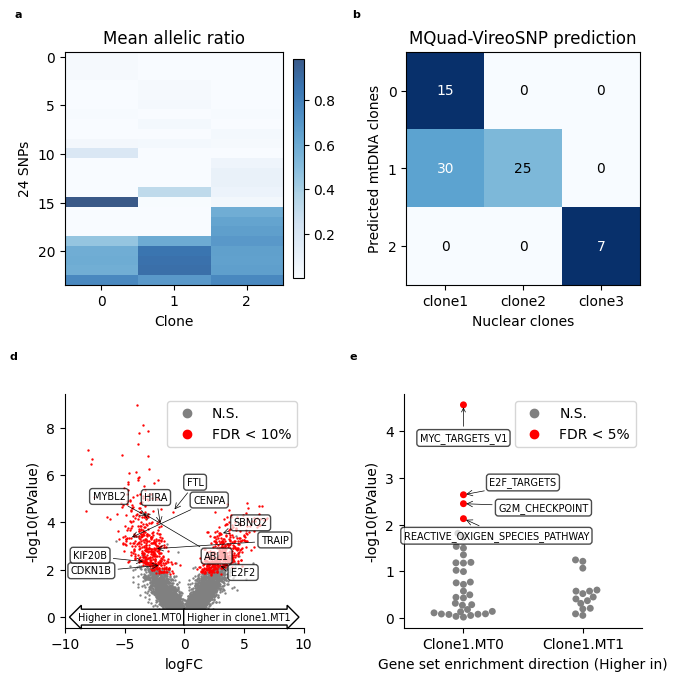

In [41]:
cm = 1/2.54
fig = plt.figure(figsize=(10,7), dpi=100)
ax = plt.subplot(2,3,1)
ax.text(-0.5*cm, 3*cm, 'a', transform = ax.transAxes, fontsize = 8, fontweight = 'bold', va='top', ha='right')
AF_SNPs = mquad_modelCA.beta_mu
#rearrange clones to match fig 3b
AF_SNPs_sorted = np.array([[i[2], i[0], i[1]]for i in AF_SNPs])
im = heat_matrix(AF_SNPs_sorted, cmap="Blues", alpha=0.8, 
                 display_value=False, row_sort=True, interpolation='none', aspect='auto')
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.title("Mean allelic ratio")
plt.xlabel("Clone")
plt.ylabel("%d SNPs" %(mquad_modelCA.n_var))
plt.xticks(range(mquad_modelCA.n_donor))
plt.tight_layout()

#mquad confusion matrix
ax = plt.subplot(2,3,2)
ax.text(-0.5*cm, 3*cm, 'b', transform = ax.transAxes, fontsize = 8, fontweight = 'bold', va='top', ha='right')
clone_id = np.argmax(ID_prob_sorted, axis=1)

real_df = pd.read_csv('data/cardelino_clones_files.csv')
real_lab = [i for i in real_df.V2 if i != 'unassigned']
confusion = confusionMatrix(clone_id, real_lab)
#confusion = confusion[["Clone 1", "Clone 2", "Clone 3"]]
res = plot_confusionMatrix(confusion, ax)
plt.title('MQuad-VireoSNP prediction')
plt.ylabel('Predicted mtDNA clones')
plt.xlabel('Nuclear clones')
plt.xticks(range(3), confusion.columns)
plt.yticks(range(len(confusion)), set(clone_id))
plt.tight_layout()

ax = plt.subplot(2,3,4)
ax.text(-0.5*cm, 3*cm, 'd', transform = ax.transAxes, fontsize = 8, fontweight = 'bold', va='top', ha='right')
de_tab_sig = de_tab[de_tab.sig == True]
de_tab_not_sig = de_tab[de_tab.sig == False]

ax.scatter(de_tab_not_sig.logFC, -np.log10(de_tab_not_sig.PValue), color = 'grey', label = 'N.S.', s=0.5)
ax.scatter(de_tab_sig.logFC, -np.log10(de_tab_sig.PValue), color='r', label = 'FDR < 10%', s=0.5)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
legend_elements = [Line2D([0], [0], marker = 'o', color = 'grey', label = 'N.S.', linestyle = 'None'), 
Line2D([0], [0], marker = 'o', color = 'r', label = 'FDR < 10%', linestyle = 'None')]
ax.legend(handles = legend_elements)
ax.text(-0.2, 0, 'Higher in clone1.MT0', ha='right', va='center', bbox = dict(boxstyle="larrow", fc='white', lw=1), fontsize = 7)
ax.text(0.2, 0, 'Higher in clone1.MT1', ha='left', va='center', bbox = dict(boxstyle="rarrow", fc='white', lw=1), fontsize = 7)
plt.xlim([-10,10])
plt.xlabel('logFC')
plt.ylabel('-log10(PValue)')

texts = []
props = dict(boxstyle='round', alpha = 0.7, facecolor='white')
for x,y,s in zip(de_tab_sig[de_tab_sig.lab.notnull()].logFC, -np.log10(de_tab_sig[de_tab_sig.lab.notnull()].PValue), de_tab_sig[de_tab_sig.lab.notnull()].lab):
    texts.append(plt.text(x,y,s, fontsize = 7, bbox=props))

adjust_text(texts, force_text = 1.5, force_points = 1.5, expand_points=(1.5, 2), expand_text=(1.5, 1.5), arrowprops = dict(arrowstyle="->", color='black', lw=0.5))

ax = plt.subplot(2,3,5)
ax.text(-0.5*cm, 3*cm, 'e', transform = ax.transAxes, fontsize = 8, fontweight = 'bold', va='top', ha='right')
cam_H_pw_not_sig = cam_H_pw[cam_H_pw.sig == False]
cam_H_pw_sig = cam_H_pw[cam_H_pw.sig == True]
#cam_H_pw.head()

sns.swarmplot(x = cam_H_pw.Direction, y = -np.log10(cam_H_pw.PValue), hue = cam_H_pw.sig, palette = ['grey', 'r'], ax=ax)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
legend_elements = [Line2D([0], [0], marker = 'o', color = 'grey', label = 'N.S.', linestyle = 'None'), 
Line2D([0], [0], marker = 'o', color = 'r', label = 'FDR < 5%', linestyle = 'None')]
ax.legend(handles = legend_elements, loc='best')
plt.xticks(range(2), ['Clone1.MT0', 'Clone1.MT1'])
plt.xlabel('Gene set enrichment direction (Higher in)')
plt.ylabel('-log10(PValue)')

texts=[]
for y,s in zip(-np.log10(cam_H_pw_sig[cam_H_pw_sig.lab.notnull()].PValue), cam_H_pw_sig[cam_H_pw_sig.lab.notnull()].lab):
    if s != "HALLMARK_MYC_TARGETS_V1":
        s = re.sub("HALLMARK_", "", s)
        texts.append(plt.text(0,y,s, fontsize = 7, bbox=props))

adjust_text(texts, force_text = 1.5, force_points = 1.5, expand_points=(1.5, 2), expand_text=(2, 2), ha='left',arrowprops = dict(arrowstyle="->", color='black', lw=0.5))

##separately annotate myc targets to avoid overlapping with legend
ax.annotate("MYC_TARGETS_V1", xy=(0,-np.log10(0.000027)), xytext=(0,3.8), bbox=props, fontsize = 7, ha='center', arrowprops = dict(arrowstyle="->", color='black', lw=0.5))



plt.tight_layout()
plt.savefig('figures/tmp.png')

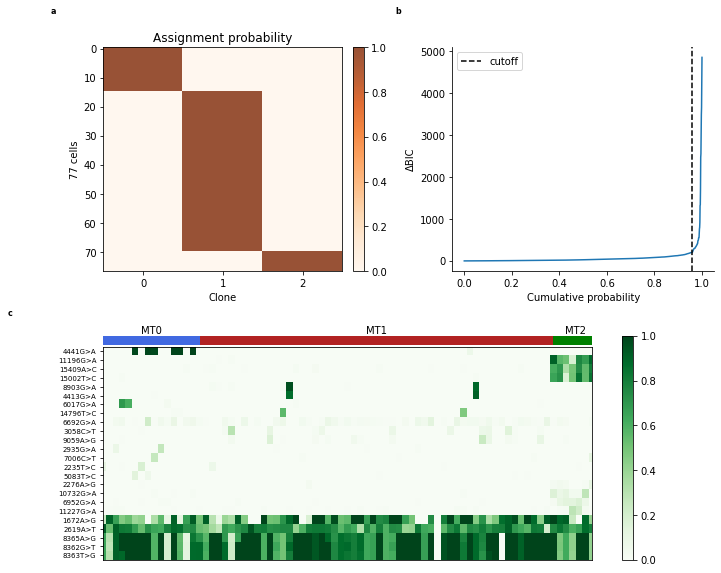

In [39]:
## supp
cm = 1/2.54
fig = plt.figure(figsize=(10,8))
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

ax = plt.subplot2grid((2,2), (0,0), colspan=1)
ax.text(-0.5*cm, 3*cm, 'a', transform = ax.transAxes, fontsize = 8, fontweight = 'bold', va='top', ha='right')
im = heat_matrix(ID_prob_sorted, cmap="Oranges", alpha=0.8,
                 display_value=False, row_sort=True, interpolation = 'none')
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.title("Assignment probability")
plt.xlabel("Clone")
plt.ylabel("%d cells" %(mquad_modelCA.n_cell))
plt.xticks(range(mquad_modelCA.n_donor))


ax = plt.subplot2grid((2,2), (0,1), colspan=1)
ax.text(-0.5*cm, 3*cm, 'b', transform = ax.transAxes, fontsize = 8, fontweight = 'bold', va='top', ha='right')
mquad = pd.read_csv('data/mquad/BIC_params.csv')
x,y,knee_x, knee_y = findKnee(mquad.deltaBIC)
plt.plot(x,y)
plt.axvline(x=knee_x, linestyle='--', color='black', label='cutoff')
plt.legend()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xlabel('Cumulative probability')
plt.ylabel('\u0394BIC')

ax = plt.subplot2grid((2,2), (1,0), colspan=2)
ax.text(-0.5*cm, 3*cm, 'c', transform = ax.transAxes, fontsize = 8, fontweight = 'bold', va='top', ha='left')
res = ax.imshow(sorted_AF.iloc[g.dendrogram_row.reordered_ind,:], cmap='Greens', aspect='auto', interpolation='none')
ax.set_yticks(range(len(sorted_AF)))
ax.set_yticklabels(sorted_AF.iloc[g.dendrogram_row.reordered_ind,:].index, fontsize = 7)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)
plt.colorbar(res)

divider = make_axes_locatable(ax)
top_ax = divider.append_axes("top", size=0.13, pad=0.02, sharex=ax)
label_num = [len(clone_id[clone_id == 0]),len(clone_id[clone_id == 1]),len(clone_id[clone_id == 2])]
LEFT = 0
iicolor = 0
c_names = ['MT0', 'MT1', 'MT2']
clone_pal = ['royalblue', 'firebrick', 'green']
for num in label_num:
        top_ax.barh(0,num,left=LEFT,color=clone_pal[iicolor])
        top_ax.text(x=LEFT + num/2, y=1, s=c_names[iicolor], va='center', ha='center')
        top_ax.set_xlim(0,76)
        top_ax.axis('off')
        LEFT += num
        iicolor += 1

plt.tight_layout()
plt.savefig('figures/supp.pdf')